In [1]:
from jpeg_implementation.dct import block_dct2, block_idct2
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman, decode_huffman
from jpeg_implementation.quantization import quantize, quantize_inverse, \
    get_quantization_matrix_for_quality_percent
from jpeg_implementation.rgbToYuv import rgb_to_yuv, yuv_to_rgb
from jpeg_implementation.runLengthEncode import resort_and_run_length_encode, unsort_and_run_length_decode, \
    resort_values_zig_zag, run_length_encode, flatten, resort_values_zig_zag_reverse, run_length_decode, un_flatten
from jpeg_implementation.splitBlocks import split, merge_blocks
from jpeg_implementation.subsample import subsample_u_v, calculate_down_sampled_resolution, up_sample_u_v
from jpeg_implementation.serialize import store_as_file
from jpeg_implementation.EasyJpeg import EasyJpeg

import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from typing import Tuple

In [2]:
def plot_y_u_v(y_loc, u_loc, v_loc, colormap=True):
    fig_loc, ax_loc = plt.subplots(1, 3, figsize=(15, 20))
    ax_loc[0].imshow(y_loc, cmap="gray")
    ax_loc[0].set_title("Y Component")

    # creating a linear colormap, based on the values of the example https://commons.wikimedia.org/wiki/File:Barn-yuv.png
    if colormap:
        cmap_u = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, 177 / 255, 78 / 255, 1),
                                                                          (0, 86 / 255, 169 / 255, 1)])
    else:
        cmap_u = matplotlib.colormaps["gray"]
    ax_loc[1].imshow(u_loc, cmap=cmap_u)
    ax_loc[1].set_title("U Component")

    if colormap:
        cmap_v = matplotlib.colors.LinearSegmentedColormap.from_list("", [(104 / 255, 151 / 255, 0, 1),
                                                                          (171 / 255, 84 / 255, 0)])
    else:
        cmap_v = matplotlib.colormaps["gray"]
    ax_loc[2].imshow(v_loc, cmap=cmap_v)
    ax_loc[2].set_title("V Component")
    plt.show()

In [3]:
images = {
    "christmas_tree_6000x4000": "images/christmas_tree_6000x4000.png",
    "christmas_tree_600x400": "images/christmas_tree_600x400.png",
    "christmas_tree_194x129": "images/christmas_tree_194x129.png",
    "Barns_grand_tetons_1600x1195": "images/Barns_grand_tetons_1600x1195.png",
    "lenna_512x512": "images/lenna_512x512.png",
    "lenna_256x256": "images/lenna_256x256.png",
    "lenna_128x128": "images/lenna_128x128.png",
    "lenna_64x64": "images/lenna_64x64.png",
    "lenna_32x32": "images/lenna_32x32.png",
}

In [4]:
# image which should be encoded
image_path = images["lenna_32x32"]

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 2, 0)  # can be (4,1,0), (4,1,1), (4,2,0), (4,2,2), (4,4,4)
quantization_table_quality: int = 70  # percentage of quantization quality 0..100

[[158 156 165 147  98 106 110 124]
 [157 159 164 144  95 105 108 122]
 [161 163 161 142  94 104 108 121]
 [165 139 161 145  90 101 108 121]
 [152 106 164 142  85 100 105 116]
 [109 105 164 141  87 100 105 117]
 [ 91 105 162 142  86  99 104 116]
 [ 91 103 161 142  83  98 104 122]]


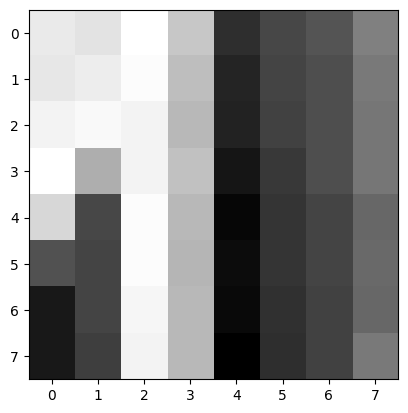

In [5]:
original_image = plt.imread(image_path)



# strip alpha channel if exists
if original_image.shape[2] == 4:
    channels = np.dsplit(original_image, 4)
    original_image = np.dstack(channels[:3])
# select only 8x8 matrix
original_image = original_image[:8, :8]
# convert to grayscale
original_image = np.dot(original_image[...,:3], [0.299, 0.587, 0.114])

# make image with 3 dimensions for compability
#original_image = np.dstack([original_image, original_image, original_image])

# convert range from 0..1 to int (0..255)
original_image *= 255
original_image = np.rint(original_image)
original_image = original_image.astype(int)

original_image_resolution = tuple(reversed(original_image.shape[:2]))

#matrix_image = np.dsplit(original_image,3)[0].reshape(8,8)

fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")
print(np.matrix(original_image))

## Step 4
### Apply dct

In [6]:
trans = block_dct2(original_image - 128, block_size)

In [7]:
print(np.round(trans,3))

[[ 22.716  29.113  26.342  11.589 -44.815 -28.815  -9.226   4.734]
 [ 20.53   30.835  25.829   7.534 -48.093 -29.547 -10.505   3.943]
 [ 22.656  35.618  23.6     3.84  -48.818 -30.466 -10.235   3.203]
 [ 31.889  16.015  14.804  11.468 -52.689 -31.663  -8.349   4.183]
 [ 28.108 -18.873   8.607  16.374 -58.148 -29.66  -10.229   2.02 ]
 [-11.483 -33.224  15.697  17.038 -53.131 -27.986  -8.906   3.49 ]
 [-28.961 -38.285  16.25   17.834 -52.622 -28.813  -8.845   3.296]
 [-28.803 -39.434  14.458  18.613 -54.557 -27.923  -6.082   9.098]]


## Step 5
### Quantization


In [8]:
quantization_table = get_quantization_matrix_for_quality_percent(quantization_table_quality)

quantized = quantize([trans], quantization_table)

print(quantized[0])

[[ 2.  4.  4.  1. -3. -1. -0.  0.]
 [ 3.  4.  3.  1. -3. -1. -0.  0.]
 [ 3.  4.  2.  0. -2. -1. -0.  0.]
 [ 4.  2.  1.  1. -2. -1. -0.  0.]
 [ 3. -1.  0.  0. -1. -0. -0.  0.]
 [-1. -2.  0.  0. -1. -0. -0.  0.]
 [-1. -1.  0.  0. -1. -0. -0.  0.]
 [-1. -1.  0.  0. -1. -0. -0.  0.]]


## Step 6
### Reordering of values, Run Length Encoding

In [9]:
resorted = resort_values_zig_zag(quantized, block_size)
encoded_blocks = run_length_encode(resorted)
rl_encoded = flatten(encoded_blocks)

print(encoded_blocks)
print(rl_encoded)

[(2.0, 1), (4.0, 1), (3.0, 2), (4.0, 2), (1.0, 1), (3.0, 1), (4.0, 2), (3.0, 1), (2.0, 2), (1.0, 1), (-3.0, 1), (-1.0, 1), (-3.0, 1), (0.0, 1), (1.0, 1), (-1.0, 3), (-2.0, 1), (0.0, 1), (1.0, 1), (-2.0, 1), (-1.0, 1), (-0.0, 3), (-1.0, 1), (-2.0, 1), (0.0, 2), (-1.0, 3), (0.0, 2), (-1.0, 2), (-0.0, 5), (-1.0, 1), (0.0, 3), (-1.0, 1), (-0.0, 6), (-1.0, 1), (-0.0, 6)]
[2.0, 1, 4.0, 1, 3.0, 2, 4.0, 2, 1.0, 1, 3.0, 1, 4.0, 2, 3.0, 1, 2.0, 2, 1.0, 1, -3.0, 1, -1.0, 1, -3.0, 1, 0.0, 1, 1.0, 1, -1.0, 3, -2.0, 1, 0.0, 1, 1.0, 1, -2.0, 1, -1.0, 1, -0.0, 3, -1.0, 1, -2.0, 1, 0.0, 2, -1.0, 3, 0.0, 2, -1.0, 2, -0.0, 5, -1.0, 1, 0.0, 3, -1.0, 1, -0.0, 6, -1.0, 1, -0.0, 6]


## Step 7
### Huffman Encoding

In [10]:
huffman_code = generate_huffman_code(rl_encoded)
huff_encoded = encode_huffman(huffman_code, rl_encoded)


In [11]:
print(huffman_code)
print(huff_encoded)

{6: '1111', 4.0: '1110', -2.0: '1101', 5: '11001', -3.0: '11000', 3.0: '101', 2.0: '100', -1.0: '011', 0.0: '010', 1: '00'}
1000011100010110011101000000101001110100101001001000000110000001100110000001000000001110111010001000000011010001100010101011001101000101000111010101000111000101100101100010101011000101111011000101111


## Step 10
### Decode Huffman

In [12]:
rl_encoded = decode_huffman(huff_encoded, huffman_code)
print(rl_encoded)

[2.0, 1, 4.0, 1, 3.0, 2.0, 4.0, 2.0, 1, 1, 3.0, 1, 4.0, 2.0, 3.0, 1, 2.0, 2.0, 1, 1, -3.0, 1, -1.0, 1, -3.0, 1, 0.0, 1, 1, 1, -1.0, 3.0, -2.0, 1, 0.0, 1, 1, 1, -2.0, 1, -1.0, 1, 0.0, 3.0, -1.0, 1, -2.0, 1, 0.0, 2.0, -1.0, 3.0, 0.0, 2.0, -1.0, 2.0, 0.0, 5, -1.0, 1, 0.0, 3.0, -1.0, 1, 0.0, 6, -1.0, 1, 0.0, 6]


## Step 11
### Decode run-length encoding + Reordering of values

In [15]:
un_flattened = un_flatten(rl_encoded)
block_zig_zag = run_length_decode(un_flattened)
block = resort_values_zig_zag_reverse(block_zig_zag, block_size)

print(block)

[[ 2.  4.  4.  1. -3. -1.  0.  0.]
 [ 3.  4.  3.  1. -3. -1.  0.  0.]
 [ 3.  4.  2.  0. -2. -1.  0.  0.]
 [ 4.  2.  1.  1. -2. -1.  0.  0.]
 [ 3. -1.  0.  0. -1.  0.  0.  0.]
 [-1. -2.  0.  0. -1.  0.  0.  0.]
 [-1. -1.  0.  0. -1.  0.  0.  0.]
 [-1. -1.  0.  0. -1.  0.  0.  0.]]


## Step 12
### Apply inverse quantization

In [17]:
iq = quantize_inverse([block], quantization_table)
print(iq)

[[[ 20.  28.  24.  10. -42. -24.   0.   0.]
  [ 21.  28.  24.  11. -48. -35.   0.   0.]
  [ 24.  32.  20.   0. -48. -34.   0.   0.]
  [ 32.  20.  13.  17. -62. -52.   0.   0.]
  [ 33. -13.   0.   0. -41.   0.   0.   0.]
  [-14. -42.   0.   0. -49.   0.   0.   0.]
  [-29. -38.   0.   0. -62.   0.   0.   0.]
  [-43. -55.   0.   0. -67.   0.   0.   0.]]]


## Step 13
### Apply inverse DCT

[[154.929 154.925 160.841 144.643  97.318 108.617 120.668 123.156]
 [156.608 155.409 162.876 148.141  93.121  98.329 117.843 120.302]
 [161.573 159.465 157.159 138.803  92.537  97.486 117.282 119.498]
 [167.518 142.46  161.553 156.232  81.218  81.945 111.973 114.962]
 [157.746 108.474 147.719 121.538  93.935 123.411 121.587 123.559]
 [105.509  94.757 146.083 118.028  82.734 119.749 116.489 119.395]
 [ 93.651 102.272 145.563 119.646  68.761 119.588 112.981 117.83 ]
 [ 75.71   90.782 147.42  116.615  63.385 117.278 110.789 115.734]]


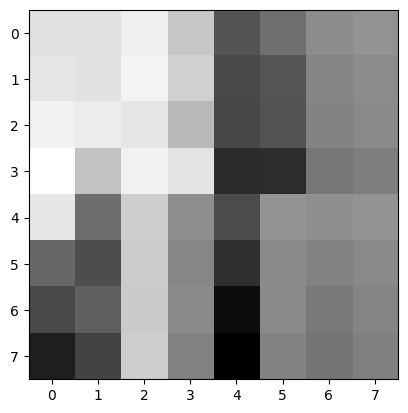

In [27]:
id = block_idct2(iq[0], block_size) + 128
print(np.round(id,3))

fig, ax = plt.subplots()
ax.imshow(id, cmap="gray")

[[158 156 165 147  98 106 110 124]
 [157 159 164 144  95 105 108 122]
 [161 163 161 142  94 104 108 121]
 [165 139 161 145  90 101 108 121]
 [152 106 164 142  85 100 105 116]
 [109 105 164 141  87 100 105 117]
 [ 91 105 162 142  86  99 104 116]
 [ 91 103 161 142  83  98 104 122]]


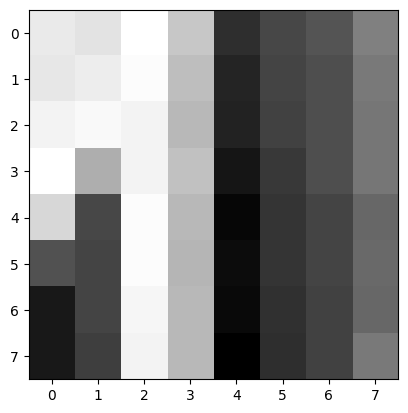

In [28]:
print(original_image)
fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")